In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torch
plt.rcParams["image.cmap"] = "gray"
import deepinv as dinv


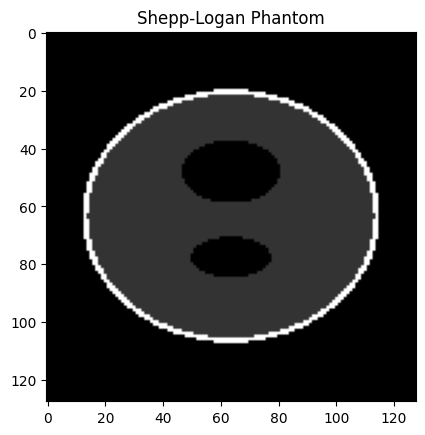

In [7]:
def phantom3d(*args):
    ellipse, n = parse_inputs(*args)
    p = np.zeros((n, n, n))
    rng = np.linspace(-1, 1, n)
    x, y, z = np.meshgrid(rng, rng, rng)
    coord = np.vstack((x.flatten(), y.flatten(), z.flatten()))
    p = p.flatten()
    for k in range(ellipse.shape[0]):
        A = ellipse[k, 0]            # Amplitude change for this ellipsoid
        asq = ellipse[k, 1] ** 2     # a^2
        bsq = ellipse[k, 2] ** 2     # b^2
        csq = ellipse[k, 3] ** 2     # c^2
        x0 = ellipse[k, 4]           # x offset
        y0 = ellipse[k, 5]           # y offset
        z0 = ellipse[k, 6]           # z offset
        phi = ellipse[k, 7] * np.pi / 180   # first Euler angle in radians
        theta = ellipse[k, 8] * np.pi / 180 # second Euler angle in radians
        psi = ellipse[k, 9] * np.pi / 180   # third Euler angle in radians
        cphi = np.cos(phi)
        sphi = np.sin(phi)
        ctheta = np.cos(theta)
        stheta = np.sin(theta)
        cpsi = np.cos(psi)
        spsi = np.sin(psi)
        # Euler rotation matrix
        alpha = np.array([[cpsi * cphi - ctheta * sphi * spsi, cpsi * sphi + ctheta * cphi * spsi, spsi * stheta],
                          [-spsi * cphi - ctheta * sphi * cpsi, -spsi * sphi + ctheta * cphi * cpsi, cpsi * stheta],
                          [stheta * sphi, -stheta * cphi, ctheta]])
        # rotated ellipsoid coordinates
        coordp = np.dot(alpha, coord)
        idx = np.where((coordp[0, :] - x0) ** 2 / asq + (coordp[1, :] - y0) ** 2 / bsq + (coordp[2, :] - z0) ** 2 / csq <= 1)[0]
        p[idx] += A
    p = p.reshape((n, n, n))
    return p, ellipse

def flatten(in_arr):
    return in_arr.flatten()

def parse_inputs(*args):
    n = 128  # Default size
    e = None
    defaults = ['shepp-logan', 'modified shepp-logan', 'yu-ye-wang']
    for i in range(len(args)):
        if isinstance(args[i], str):  # Look for a default phantom
            def_str = args[i].lower()
            idx = defaults.index(def_str) if def_str in defaults else None
            if idx is None:
                raise ValueError('Unknown default phantom selected.')
            if defaults[idx] == 'shepp-logan':
                e = shepp_logan()
            elif defaults[idx] == 'modified shepp-logan':
                e = modified_shepp_logan()
            elif defaults[idx] == 'yu-ye-wang':
                e = yu_ye_wang()
        elif isinstance(args[i], (int, float)):  # a scalar is the image size
            n = int(args[i])
        elif isinstance(args[i], np.ndarray) and args[i].ndim == 2 and args[i].shape[1] == 10:
            e = args[i]  # user specified phantom
        else:
            raise ValueError('Invalid input arguments.')
    if e is None:
        e = modified_shepp_logan()
    return e, n

# Default head phantoms

def shepp_logan():
    return modified_shepp_logan()

def modified_shepp_logan():
    return np.array([[1, 0.6900, 0.920, 0.810, 0, 0, 0, 0, 0, 0],
                     [-0.8, 0.6624, 0.874, 0.780, 0, -0.0184, 0, 0, 0, 0],
                     [-0.2, 0.1100, 0.310, 0.220, 0.22, 0, 0, -18, 0, 10],
                     [-0.2, 0.1600, 0.410, 0.280, -0.22, 0, 0, 18, 0, 10],
                     [0.1, 0.2100, 0.250, 0.410, 0, 0.35, -0.15, 0, 0, 0],
                     [0.1, 0.0460, 0.046, 0.050, 0, 0.1, 0.25, 0, 0, 0],
                     [0.1, 0.0460, 0.046, 0.050, 0, -0.1, 0.25, 0, 0, 0],
                     [0.1, 0.0460, 0.023, 0.050, -0.08, -0.605, 0, 0, 0, 0],
                     [0.1, 0.0230, 0.023, 0.020, 0, -0.606, 0, 0, 0, 0],
                     [0.1, 0.0230, 0.046, 0.020, 0.06, -0.605, 0, 0, 0, 0]])

def yu_ye_wang():
    return np.array([[1, 0.6900, 0.920, 0.900, 0, 0, 0, 0, 0, 0],
                     [-0.8, 0.6624, 0.874, 0.880, 0, 0, 0, 0, 0, 0],
                     [-0.2, 0.4100, 0.160, 0.210, -0.22, 0, -0.25, 108, 0, 0],
                     [-0.2, 0.3100, 0.110, 0.220, 0.22, 0, -0.25, 72, 0, 0],
                     [0.2, 0.2100, 0.250, 0.500, 0, 0.35, -0.25, 0, 0, 0],
                     [0.2, 0.0460, 0.046, 0.046, 0, 0.1, -0.25, 0, 0, 0],
                     [0.1, 0.0460, 0.023, 0.020, -0.08, -0.65, -0.25, 0, 0, 0],
                     [0.1, 0.0460, 0.023, 0.020, 0.06, -0.65, -0.25, 90, 0, 0],
                     [0.2, 0.0560, 0.040, 0.100, 0.06, -0.105, 0.625, 90, 0, 0],
                     [-0.2, 0.0560, 0.056, 0.100, 0, 0.100, 0.625, 0, 0, 0]])

# Example usage:

# Create a 3D phantom

p, e = phantom3d('shepp-logan', 128)
# Display the 3D phantom
plt.figure()
plt.imshow(p[64, :, :], cmap='gray')
plt.title('Shepp-Logan Phantom')
plt.show()


In [25]:
import torch
import deepinv as dinv
from deepinv.optim import L2, TVPrior

In [31]:
import torch
import deepinv as dinv
from deepinv.optim import L2, TVPrior

# Forward operator, here inpainting
mask = torch.ones((1, 2, 2))
print(mask)
mask[0, 0, 0] = 0
print(mask)
physics = dinv.physics.Inpainting(tensor_size=mask.shape, mask=mask)
# Generate data
x = torch.ones((1, 1, 2, 2))
y = physics(x)
print(y.shape)
data_fidelity = L2()  # The data fidelity term
prior = TVPrior()  # The prior term
lambd = 0.1  # Regularization parameter
# Compute the squared norm of the operator A
norm_A2 = physics.compute_norm(y, tol=1e-4, verbose=False).item()
stepsize = 1/norm_A2  # stepsize for the PGD algorithm

# PGD algorithm
max_iter = 20  # number of iterations
x_k = torch.zeros_like(x)  # initial guess


tensor([[[1., 1.],
         [1., 1.]]])
tensor([[[0., 1.],
         [1., 1.]]])
torch.Size([1, 1, 2, 2])


In [ ]:
for it in range(max_iter):
    u = x_k - stepsize*data_fidelity.grad(x_k, y, physics)  # Gradient step
    x_k = prior.prox(u, gamma=lambd*stepsize)  # Proximal step
    cost = data_fidelity(x_k, y, physics) + lambd*prior(x_k)  # Compute the cost
